In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
# File with effective mass output.
base = 'test_pion_mass_output/'
file = base + 'cl3_16_48_b6p1_m0p2450_output1.txt'

In [3]:
# f = open(file, 'r')

# # discard the first two lines
# f.readline()
# f.readline()
# n_t = []
# C = []
# for line in f:
#     left, right = line.split(' | ')
#     real, imag = right.split(' + i(')
#     n_t.append(int(left))
#     C.append(np.complex(float(real), float(imag[:-2])))
# f.close()

In [4]:
f = open(file, 'r')

In [5]:
# New read in format: Each line after the first of form cfgId|a1+ib a2+ib ...
f.readline()
L3 = 48    #temporal extent of lattice
C = []
for line in f:
    cur_line = np.zeros(L3, dtype=complex)
    cfgIdx, rest = line.split('|')
    cfgIdx = int(cfgIdx)
    interps = rest.split(' ')    # now get real and complex
    for n_t, x in enumerate(interps):
        if not x.isspace():
            real, imag = x.split('+i(')    #form should be x = a+i(b)
            real = float(real)
            imag = float(imag.replace(')', ''))
            cur_line[n_t] = complex(real, imag)
    print(cur_line)
    cur_line = [cur_line]
    if C == []:
        C = np.array(cur_line)
    else:
        C = np.append(C, cur_line, axis = 0)
# ideally C should be a #configs x L3 array, so C[i, j] indexes configuration i with time extent j

[-1.889547e-01-1.134953e-19j -2.855765e-03+9.196189e-20j
 -4.506974e-04+1.203795e-20j -1.372412e-05+2.256227e-23j
 -2.255484e-06+3.974546e-23j -3.212291e-07-1.125894e-24j
 -3.811094e-08+2.991785e-25j -3.843921e-09+5.463484e-26j
 -4.585058e-10-1.489013e-27j -7.879979e-11-1.007212e-28j
 -8.972237e-12-6.203550e-30j -1.104414e-12-1.277978e-30j
 -1.054790e-13-1.056506e-31j -1.127551e-14+4.429370e-32j
 -1.049482e-15+6.599120e-33j -9.933001e-17-1.830527e-34j
 -7.504164e-18-5.877996e-36j -5.713021e-19+3.581252e-37j
 -4.693281e-20-2.087287e-37j -3.152874e-21-1.287523e-38j
 -2.027165e-22-7.659171e-40j -1.454698e-23-7.395438e-41j
 -8.980155e-25+1.184240e-41j -6.535174e-26+9.345706e-44j
 -6.724688e-27+5.003677e-44j -4.088896e-26+1.608089e-43j
 -6.622201e-25-1.501906e-42j -9.152556e-24+2.298731e-41j
 -1.387137e-22-4.030742e-40j -1.473966e-21+7.128810e-39j
 -2.223203e-20-2.696065e-38j -2.458244e-19+1.720780e-37j
 -3.018072e-18+1.503327e-35j -3.601199e-17-1.363378e-34j
 -3.585415e-16-8.800289e-34j -3

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[-1.989237e-01+1.949296e-19j -3.496349e-03-6.376273e-20j
 -3.044298e-04-7.862132e-21j -2.562533e-05+4.673627e-22j
 -3.271755e-06+1.574358e-23j -3.211116e-07+2.387827e-24j
 -3.251625e-08+3.193581e-25j -3.674170e-09+1.584362e-26j
 -4.725181e-10+2.838625e-28j -5.334764e-11+4.443137e-29j
 -7.714542e-12-1.994820e-29j -6.241582e-13-1.995317e-30j
 -7.876399e-14+2.872427e-31j -9.004743e-15+7.418463e-34j
 -9.484352e-16+4.064096e-33j -1.001292e-16-6.046311e-34j
 -8.223888e-18-2.555535e-35j -7.991111e-19+6.084185e-36j
 -6.342191e-20+2.211650e-37j -4.677262e-21-3.483749e-38j
 -2.719444e-22-7.371154e-40j -1.637611e-23-6.829018e-41j
 -1.250594e-24+7.024980e-42j -8.706296e-26-2.701645e-43j
 -6.524858e-27+1.773299e-44j -2.785377e-26-2.655795e-44j
 -4.304521e-25-8.601426e-43j -6.027739e-24-8.306063e-42j
 -9.657838e-23-9.527991e-40j -1.429060e-21+3.765193e-39j
 -1.839607e-20-5.866169e-38j -2.191216e-19-1.012213e-37j
 -2.847207e-18+1.988750e-36j -3.788304e-17-3.341367e-34j
 -3.536849e-16-2.018269e-33j -3

[-1.885880e-01+1.047071e-19j -1.684006e-03-3.113669e-20j
 -2.075746e-04-6.494091e-22j -4.211276e-05+1.727652e-23j
 -3.595074e-06-5.684707e-23j -4.176018e-07+2.218126e-25j
 -4.355413e-08-8.117172e-25j -3.659175e-09+1.998470e-26j
 -5.699049e-10+1.472075e-28j -7.404847e-11+4.959414e-30j
 -6.872398e-12-3.591979e-29j -8.921354e-13+4.331006e-30j
 -9.517212e-14-6.735254e-31j -8.408106e-15+2.581564e-32j
 -9.534627e-16-5.865182e-34j -1.081229e-16+2.792412e-35j
 -8.176579e-18-3.271388e-35j -6.836853e-19+9.660752e-37j
 -6.550985e-20+2.237911e-37j -5.092173e-21+6.587867e-39j
 -3.198673e-22-2.825704e-39j -2.160545e-23+1.284941e-40j
 -1.105807e-24-2.753209e-42j -7.109884e-26-4.693591e-43j
 -7.614150e-27-8.612823e-45j -6.256015e-26+6.125656e-43j
 -1.187050e-24+6.588354e-42j -2.053851e-23-5.797413e-41j
 -2.780043e-22+1.661853e-39j -4.290374e-21+7.982243e-39j
 -6.154499e-20+1.212853e-37j -9.091268e-19+3.822085e-36j
 -1.028896e-17-6.101141e-35j -1.426276e-16+4.476178e-34j
 -1.359985e-15-3.214366e-33j -1

In [6]:
Cavg = np.mean(np.abs(C), axis = 0)    #each of these should be a L3 size list
σ = np.std(np.abs(C), axis = 0)

In [7]:
m = []
σ_m = []
for i in range(L3 - 1):
    m.append(np.log(Cavg[i] / Cavg[i + 1]))
    σ_m.append(np.sqrt((σ[i] / Cavg[i])**2 + (σ[i + 1] / Cavg[i + 1])**2))

Text(0, 0.5, '$log(C(n_t))$')

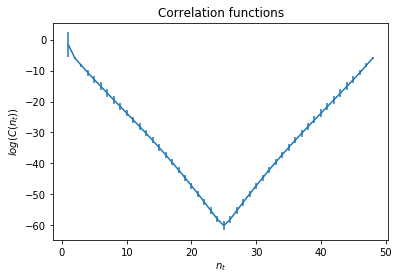

In [8]:
σ_logC = σ / Cavg    #σ_{log(C)} = σ_C / C
plt.figure()
# plt.scatter(n_t, np.log(np.abs(C)))
plt.errorbar(range(1, n_t + 1), np.log(np.abs(Cavg)), yerr = np.log(σ_logC))
plt.title('Correlation functions')
plt.xlabel('$n_t$')
plt.ylabel('$log(C(n_t))$')

Text(0, 0.5, '$m_{eff}$')

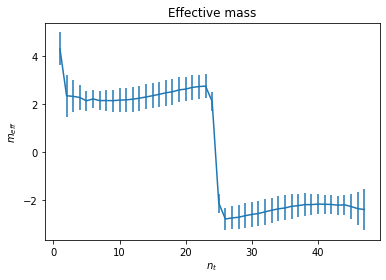

In [9]:
plt.figure()
plt.errorbar(range(1, n_t), m, yerr = σ_m)
plt.title('Effective mass')
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')